# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

import tensorflow as tf
from tensorflow import keras
from keras import layers
import gc

import warnings
warnings.filterwarnings('ignore')

# Data Analysis

In [2]:
df = pd.read_csv('../input/tabular-playground-series-oct-2022/train_0.csv')
df.shape

(2149381, 61)

In [3]:
df.head()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.8048,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.2616,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.2270,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993190,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.8984,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.9606,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


#### Even if team_scoring_next is B the team_B_scoring_within_10sec is 0 this is because the event time is -33 that implies that there is still 33 sec in the game to come to an end. And the target column is about last 10sec this is why is contains 0.

Some of the important points regarding extra columns than the testing data is that:
* game_num, event_id, event_time these three are not there in the testing data.
* player_scoring_next or team_scoring_next contain informaton regarding the target variable.******

In [4]:
for col in df.columns:
    k = df[col].isnull().sum()
    if k > 0:
        print(col, '->', k)        

p0_pos_x -> 18991
p0_pos_y -> 18991
p0_pos_z -> 18991
p0_vel_x -> 18991
p0_vel_y -> 18991
p0_vel_z -> 18991
p0_boost -> 18991
p1_pos_x -> 18620
p1_pos_y -> 18620
p1_pos_z -> 18620
p1_vel_x -> 18620
p1_vel_y -> 18620
p1_vel_z -> 18620
p1_boost -> 18620
p2_pos_x -> 19517
p2_pos_y -> 19517
p2_pos_z -> 19517
p2_vel_x -> 19517
p2_vel_y -> 19517
p2_vel_z -> 19517
p2_boost -> 19517
p3_pos_x -> 19830
p3_pos_y -> 19830
p3_pos_z -> 19830
p3_vel_x -> 19830
p3_vel_y -> 19830
p3_vel_z -> 19830
p3_boost -> 19830
p4_pos_x -> 18531
p4_pos_y -> 18531
p4_pos_z -> 18531
p4_vel_x -> 18531
p4_vel_y -> 18531
p4_vel_z -> 18531
p4_boost -> 18531
p5_pos_x -> 19063
p5_pos_y -> 19063
p5_pos_z -> 19063
p5_vel_x -> 19063
p5_vel_y -> 19063
p5_vel_z -> 19063
p5_boost -> 19063
team_scoring_next -> 506604


### We will be removing team_scoring_next column any how and in the remaining columns removing 20000 data points from 2 million rows of data is not going to effect the model's performance much.

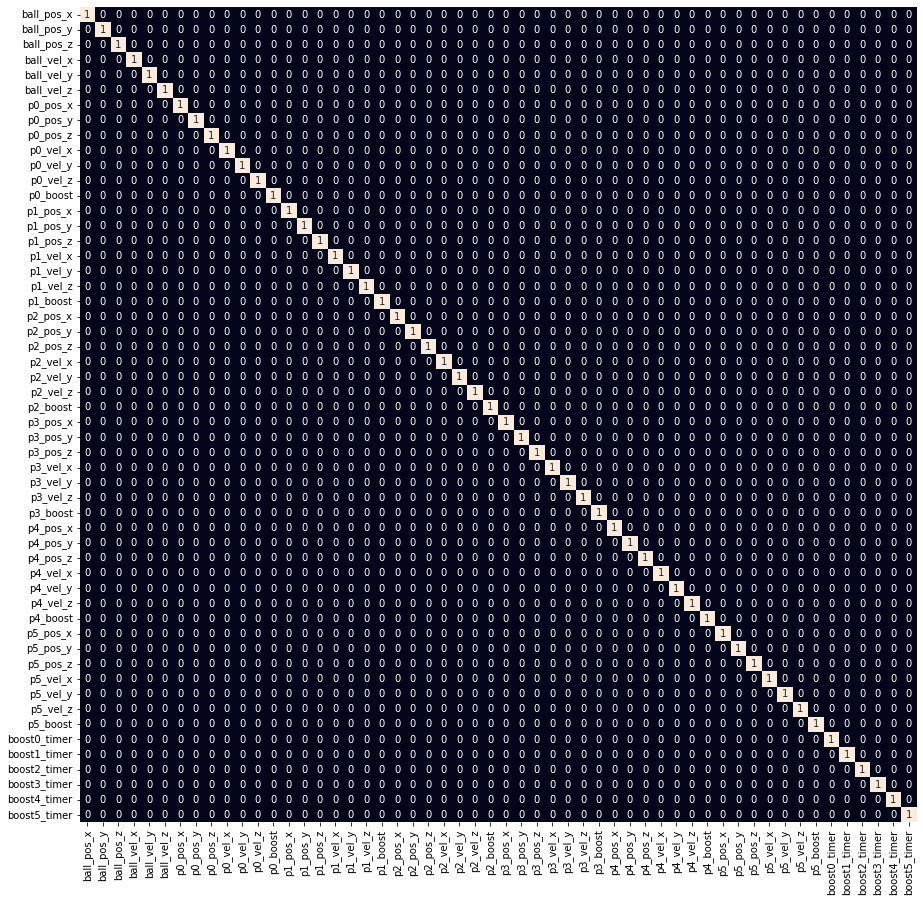

In [5]:
features = df.loc[:,'ball_pos_x':'boost5_timer']

plt.figure(figsize=(15,15))
sb.heatmap(features.corr() > 0.8, annot=True, cbar=False)
plt.show()

#### Here we can see that there are no highly correlated features here.

# Model Development

In [8]:
model = keras.models.Sequential([
    layers.Dense(256, activation='relu', input_shape=[54]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['AUC', 'accuracy'])

2022-10-07 15:36:22.918846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 15:36:23.018585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 15:36:23.019533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 15:36:23.020906: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14080     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1

In [10]:
to_remove = ['game_num', 'event_id', 'event_time', 'player_scoring_next', 'team_scoring_next']

### In the logical XOR part what I have done is created an extra column which will contain 1 if none of the two teams has scored a goal in next 10 sec otherwise it will contain 0.

In [11]:
for i in trange(10):
    path = f'../input/tabular-playground-series-oct-2022/train_{i}.csv'
    df = pd.read_csv(path)
    
#    Data loading and preprocessing 
    df['no_team_scored'] = np.logical_xor(df['team_A_scoring_within_10sec'],
                                          df['team_B_scoring_within_10sec'])
    df['no_team_scored'] = (~df['no_team_scored']).astype(int)
    
    df.drop(to_remove, axis=1, inplace=True)
    df.dropna(inplace=True, axis=0)
    
    features = df.loc[:,'ball_pos_x':'boost5_timer']
    target = df.loc[:,'team_A_scoring_within_10sec':'no_team_scored']

    X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size = 0.03,
                                      random_state=22)
    
    print(f'Training on dataset number {i+1}.')
    
    model.fit(X_train, Y_train,
              batch_size=64,
              epochs=1,
              verbose=1,
              validation_data=(X_val, Y_val))
    
    del df, X_train, X_val, Y_train, Y_val
    gc.collect()
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Training on dataset number 1.


2022-10-07 15:36:46.550002: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 854604432 exceeds 10% of free system memory.
2022-10-07 15:36:47.517204: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 854604432 exceeds 10% of free system memory.
2022-10-07 15:36:48.460333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


30911/30911 [==============================] - 159s 5ms/step - loss: 0.3890 - auc: 0.9482 - accuracy: 0.8871 - val_loss: 0.3601 - val_auc: 0.9585 - val_accuracy: 0.8896

Training on dataset number 2.


2022-10-07 15:40:41.503480: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 860665392 exceeds 10% of free system memory.
2022-10-07 15:40:42.477910: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 860665392 exceeds 10% of free system memory.


31130/31130 [==============================] - 160s 5ms/step - loss: 0.3558 - auc: 0.9568 - accuracy: 0.8954 - val_loss: 0.3254 - val_auc: 0.9666 - val_accuracy: 0.8978

Training on dataset number 3.


2022-10-07 15:43:52.744638: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 844566912 exceeds 10% of free system memory.


30548/30548 [==============================] - 157s 5ms/step - loss: 0.3593 - auc: 0.9560 - accuracy: 0.8940 - val_loss: 0.3232 - val_auc: 0.9666 - val_accuracy: 0.8990

Training on dataset number 4.
30373/30373 [==============================] - 155s 5ms/step - loss: 0.3706 - auc: 0.9536 - accuracy: 0.8902 - val_loss: 0.3418 - val_auc: 0.9629 - val_accuracy: 0.8935

Training on dataset number 5.
30413/30413 [==============================] - 155s 5ms/step - loss: 0.3614 - auc: 0.9554 - accuracy: 0.8937 - val_loss: 0.3256 - val_auc: 0.9661 - val_accuracy: 0.8981

Training on dataset number 6.
30066/30066 [==============================] - 153s 5ms/step - loss: 0.3683 - auc: 0.9538 - accuracy: 0.8914 - val_loss: 0.3339 - val_auc: 0.9640 - val_accuracy: 0.8962

Training on dataset number 7.
29637/29637 [==============================] - 125s 4ms/step - loss: 0.3764 - auc: 0.9521 - accuracy: 0.8883 - val_loss: 0.3409 - val_auc: 0.9630 - val_accuracy: 0.8937

Training on dataset number 8.


#### From the above training we can say that training on all the data has no effect on the accuracy as the accuracy score or AUC is stick to the 90% and 96% respectively.

## Predictions
One of the important factor here is predicting three classes B's score, A's Score and no ones score to get better results on the leaderboard. Due to this reason only sum of the probabilities for just A and B won't be equal to one.

In [31]:
df_test = pd.read_csv('../input/tabular-playground-series-oct-2022/test.csv')
df_test.shape

(701143, 55)

In [32]:
df_test.isnull().sum().sum()

261422

In [24]:
for col in df_test.columns:
    if df_test[col].isnull().sum() > 0:
        temp = df_test[col].mean()
        df_test[col] = df_test[col].fillna(temp)

df_test.isnull().sum().sum()

0

In [25]:
df_test.head()

,id,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,...,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer
0,0,-56.270800,29.510000,17.348600,24.4994,-1.3114,11.006801,-35.776200,73.136800,1.2480,...,3.9484,-16.710800,0.0074,71.00,0.0000,-3.264,-6.1330,-6.8750,-7.016,-3.230
1,1,2.852800,70.196000,8.949000,-8.1522,-65.5772,18.536400,22.926000,87.543800,0.3396,...,-15.4968,-14.876600,0.0050,66.70,0.0000,-1.615,-5.9700,-5.5040,0.000,-6.510
2,2,52.366400,-98.036800,14.249001,-2.0000,-45.2914,-15.423400,51.288998,-102.055595,6.3570,...,0.9058,-27.413600,0.0042,80.40,-0.0316,0.000,0.0000,-3.1290,0.000,-3.678
3,3,36.365402,53.961403,23.161798,24.8294,-10.3286,-0.918000,16.424799,0.932800,0.3402,...,-5.0532,-15.106999,0.0052,96.06,-6.4300,-4.090,-7.8320,-5.7600,0.000,-3.924
4,4,-23.262400,-53.391003,21.209600,-1.6676,-24.7788,3.481200,-19.681800,-93.913605,4.7832,...,22.2000,24.928001,0.0042,0.00,-9.8800,0.000,-0.4456,-0.4915,-7.830,0.000


In [26]:
test = df_test.loc[:,'ball_pos_x':'boost5_timer']
preds = model.predict(test)

In [27]:
preds.shape

(701143, 3)

In [28]:
ss = pd.read_csv('../input/tabular-playground-series-oct-2022/sample_submission.csv')
ss['team_A_scoring_within_10sec'] = preds[:,0]
ss['team_B_scoring_within_10sec'] = preds[:,1]
ss.to_csv('Submission.csv', index=False)
ss.head()

,id,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,0,0.024150,0.007308
1,1,0.015654,0.038091
2,2,0.058410,0.226167
3,3,0.031610,0.029647
4,4,0.010961,0.029260


#### This will be our baseline score as we have done nothing but fit and predict on the training and testing data respectively. Let's see what feature engineering or different techniques could help us to get better results than this.